In [1]:
import pandas as pd
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch
from DataLoader import Dataset
from Model import Transformer, AdamWarmup
from train import train
import torch.nn as nn
from joblib import load
from tools import *
import matplotlib.pyplot as plt
from eval import eval
import os
from datetime import datetime

In [3]:
df = pd.read_csv('Data/return/btc-usdt-1hr.csv').iloc[:,:6]
df['Open Time'] = pd.to_datetime(df['Open Time'], unit= 's')
df['Return'] = df['Close'].shift(1)/df['Close'] - 1
df = df[1:]
df

,Open Time,Open,High,Low,Close,Volume,Return
1,2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471,-0.014106
2,2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560,0.007376
3,2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077,-0.002860
4,2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803,0.001988
5,2021-01-01 05:00:00,29220.31,29235.28,29084.11,29187.01,1469.956262,0.001141
...,...,...,...,...,...,...,...
5817,2021-08-31 20:00:00,47300.00,47322.71,46914.26,46992.60,1375.538340,0.006542
5818,2021-08-31 21:00:00,46992.60,47200.00,46833.00,46911.50,1488.115700,0.001729
5819,2021-08-31 22:00:00,46911.49,47104.96,46744.57,47088.84,1359.884290,-0.003766
5820,2021-08-31 23:00:00,47091.36,47345.00,46993.00,47100.89,1242.528870,-0.000256


No handles with labels found to put in legend.


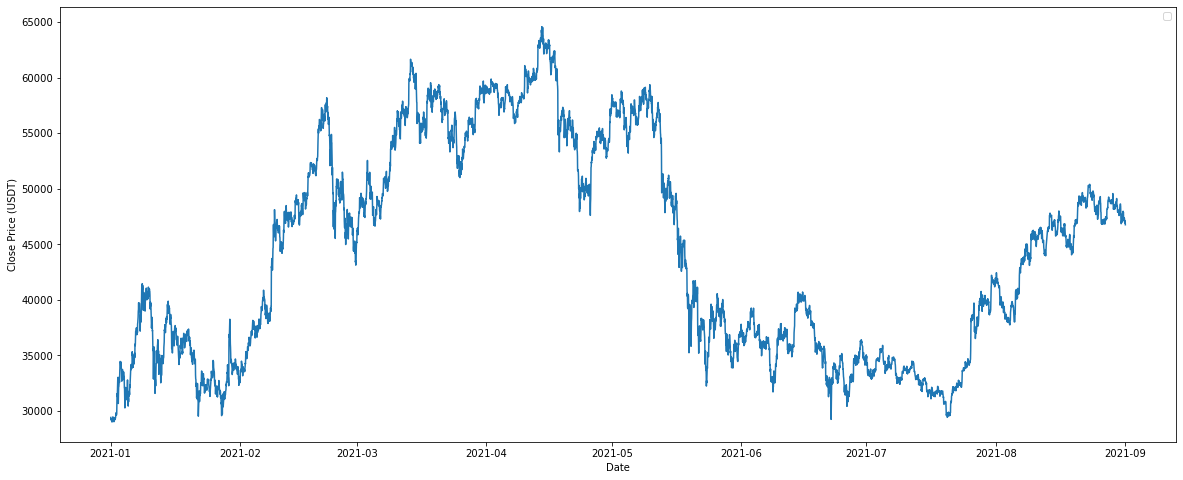

In [4]:
plt.figure(figsize=(20,8))
plt.plot(df['Open Time'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price (USDT)')
plt.legend()

No handles with labels found to put in legend.


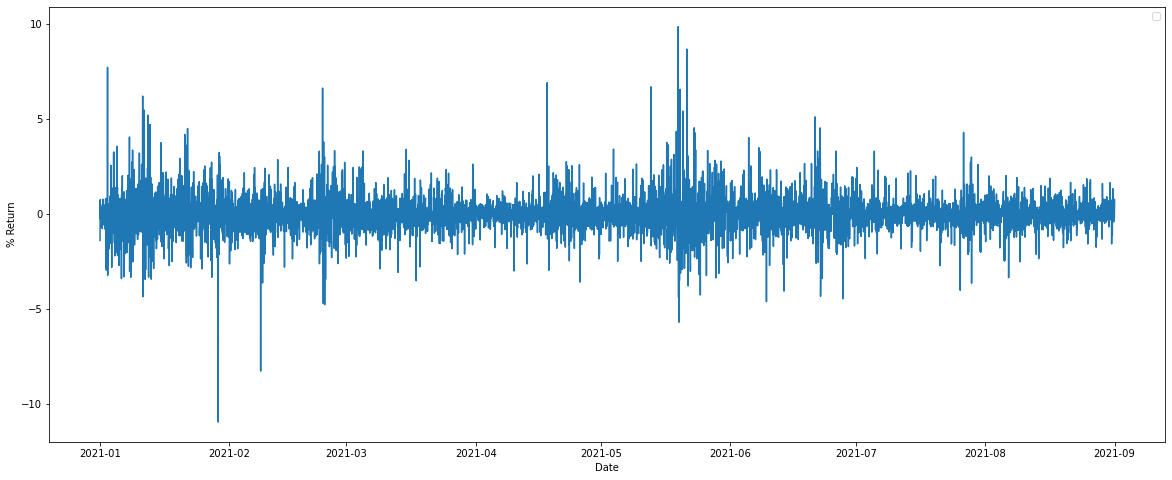

In [6]:
plt.figure(figsize=(20,8))
plt.plot(df['Open Time'], df['Return']*100)
plt.xlabel('Date')
plt.ylabel('% Return')
plt.legend()

In [2]:
#Parameters
epochs = 100
d_model = 9
nhead = 9
num_encode_layer = 3
num_decode_layer = 0 #Only need the encoder
len_input = 48
dim_feedforward = 512
len_output = 1
warmup_steps = 200
dropout = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
#Dataloader
train_dataset = Dataset('Data/return/train-btc-dataset.csv', len_input)
train_loader = DataLoader(train_dataset, batch_size= 1)

val_dataset = Dataset('Data/return/valid-btc-dataset.csv', len_input)
val_loader = DataLoader(train_dataset, batch_size= 1)

#Create model object
model = Transformer(d_model,
                    nhead = nhead,
                    num_encode_layer= num_encode_layer,
                    num_decode_layer= num_decode_layer,
                    dim_feedforward= dim_feedforward,
                    len_output = len_output,
                    dropout= dropout,
                    batch_first= True)

model.double().to(device)

#Create Adam optimizer with learning rate warmup
adam_optimizer = torch.optim.Adam(model.parameters(), lr = 0, betas=(0.9,0.98), eps = 1e-9)
adam_warmup= AdamWarmup(d_model, warmup_steps= warmup_steps, optimizer= adam_optimizer)

#Loss function
criterion = nn.MSELoss(reduction='none')

train_loss_hist = []
val_loss_hist = []
min_val_loss = float('inf')

#training loop
for epoch in range(epochs):
    train_loss, val_loss = train(train_loader= train_loader,
                                val_loader= val_loader,
                                len_input= len_input,
                                len_output= len_output,
                                model= model,
                                optim= adam_warmup,
                                criterion= criterion,
                                epoch= epoch,
                                device= device)
#     break
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_state = {
            'epoch': epoch + 1,
            'model': model.state_dict(),
            'optimizer': adam_optimizer.state_dict(),
            'training loss': train_loss,
            'validation loss': val_loss
        }

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)

    print('Epoch: [{}/{}] \t\t Trainig Loss: {:.3f}e-3 \t Validation Loss: {:.3f}e-3'.format(epoch+1, epochs, train_loss*1000, val_loss*1000))

    timestamp = int(datetime.now().timestamp())
    if early_stop(val_loss_hist, patience= 10, skip= 10):
        maybe_make_dir('checkpoints/return')
        torch.save(best_state, f'checkpoints/return/{timestamp}-{num_encode_layer}L-{len_input}HR-{dim_feedforward}FF-{warmup_steps}LRWU-{dropout}DR-Return.tar')
        break
    elif epoch+1 == epochs:
        maybe_make_dir('checkpoints/return')
        torch.save(best_state, f'checkpoints/return/{timestamp}-{num_encode_layer}L-{len_input}HR-{dim_feedforward}FF-{warmup_steps}LRWU-{dropout}DR-Return.tar')



Epoch: [1/100] 		 Trainig Loss: 15.765e-3 	 Validation Loss: 48.009e-3
Epoch: [2/100] 		 Trainig Loss: 1.727e-3 	 Validation Loss: 33.286e-3
Epoch: [3/100] 		 Trainig Loss: 1.199e-3 	 Validation Loss: 34.917e-3
Epoch: [4/100] 		 Trainig Loss: 1.172e-3 	 Validation Loss: 33.241e-3
Epoch: [5/100] 		 Trainig Loss: 1.134e-3 	 Validation Loss: 33.442e-3
Epoch: [6/100] 		 Trainig Loss: 1.094e-3 	 Validation Loss: 31.907e-3
Epoch: [7/100] 		 Trainig Loss: 1.151e-3 	 Validation Loss: 29.709e-3
Epoch: [8/100] 		 Trainig Loss: 1.100e-3 	 Validation Loss: 28.117e-3
Epoch: [9/100] 		 Trainig Loss: 1.083e-3 	 Validation Loss: 26.962e-3
Epoch: [10/100] 		 Trainig Loss: 1.106e-3 	 Validation Loss: 27.215e-3
Epoch: [11/100] 		 Trainig Loss: 1.115e-3 	 Validation Loss: 26.879e-3
Epoch: [12/100] 		 Trainig Loss: 1.144e-3 	 Validation Loss: 23.228e-3
Epoch: [13/100] 		 Trainig Loss: 1.138e-3 	 Validation Loss: 23.402e-3
Epoch: [14/100] 		 Trainig Loss: 1.141e-3 	 Validation Loss: 24.303e-3
Epoch: [15/100

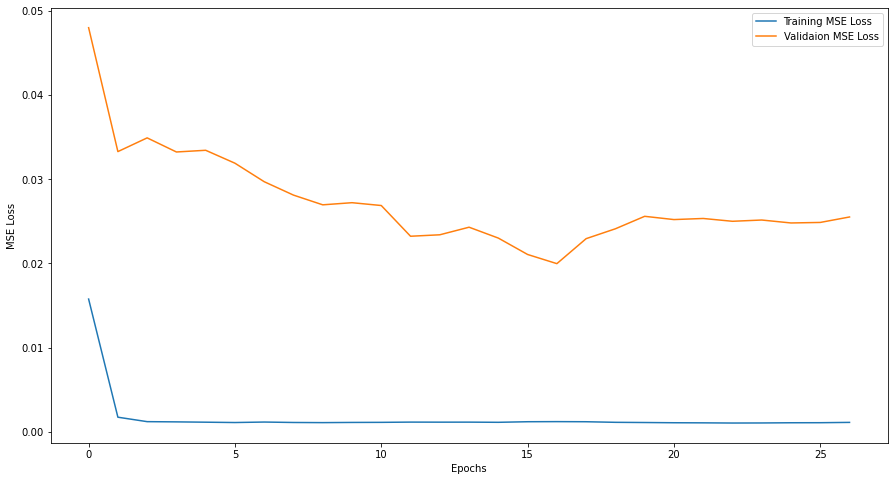

In [50]:
plt.figure(figsize=(15,8))
plt.plot(np.array(train_loss_hist), label= 'Training MSE Loss')
plt.plot(np.array(val_loss_hist), label= 'Validaion MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Prediction ended


Text(0.5, 1.0, 'Train Result')

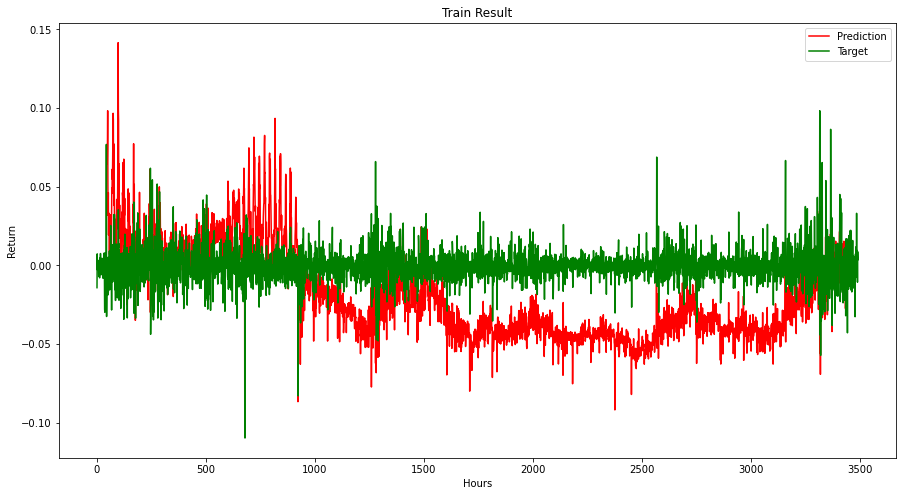

In [3]:
#predict training set
scaler = load('scalers/train-scaler-return.joblib')

model = Transformer(d_model,
                    nhead = nhead,
                    num_encode_layer= num_encode_layer,
                    num_decode_layer= num_decode_layer,
                    dim_feedforward= dim_feedforward,
                    len_output = len_output,
                    dropout= dropout,
                    batch_first= True)

checkpoint = sorted(os.listdir('checkpoints/return'), reverse= True)[0]
best_state = torch.load(f'checkpoints/return/{checkpoint}')
model.load_state_dict(best_state['model'])
model.double().to(device)

adam_optimizer = torch.optim.Adam(model.parameters(), lr = 0, betas=(0.9,0.98), eps = 1e-9)
adam_warmup= AdamWarmup(d_model, warmup_steps= warmup_steps, optimizer= adam_optimizer)
criterion = nn.MSELoss(reduction= 'none')


train_dataset = Dataset('Data/return/train-btc-dataset.csv', len_input)
train_loader = DataLoader(train_dataset, batch_size= 1)

train_pred_hist, _ = eval(train_loader, len_input, len_output, model, scaler, criterion, device=device)

for i in range(len(train_pred_hist)):
    train_pred_hist[i] = (train_pred_hist[i] * scaler.data_range_[0]) + scaler.data_min_[0]
    
train_df = pd.read_csv('Data/return/train-btc-raw.csv')
train_pred_close = {'Predicted Return' : train_pred_hist}
train_pred_df = pd.DataFrame(train_pred_close)
train_df['Predicted Return'] = train_pred_df.shift(len_input + len_output - 1)
train_df['Return'] = train_df['Close'].shift(1)/train_df['Close'] - 1

plt.figure(figsize=(15,8))
plt.xlabel('Hours')
plt.ylabel('Return')
plt.plot(train_df.index, train_df['Predicted Return'], label= 'Prediction', color= 'r'), 
plt.plot(train_df.index, train_df['Return'], label= 'Target', color= 'g')
plt.legend()
plt.title('Train Result')


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Prediction ended


Text(0.5, 1.0, 'Validation Result')

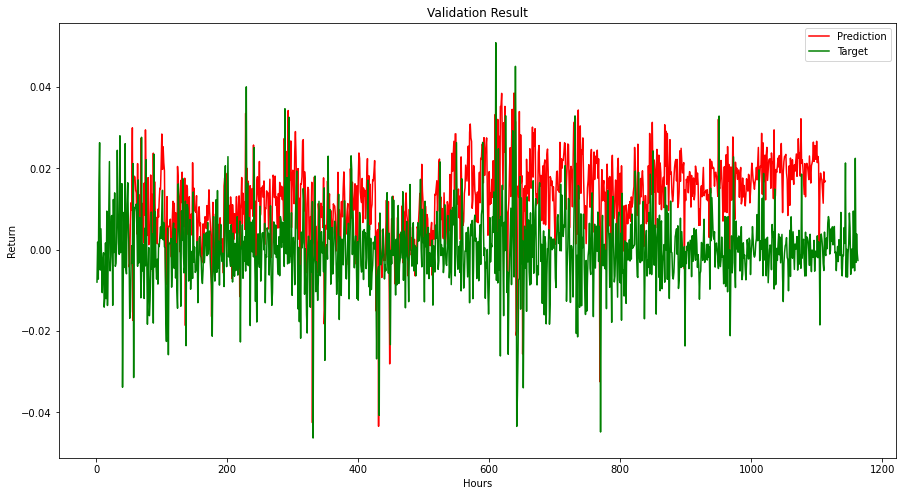

In [4]:
#Predict validation set
scaler = load('scalers/train-scaler-return.joblib')

model = Transformer(d_model,
                    nhead = nhead,
                    num_encode_layer= num_encode_layer,
                    num_decode_layer= num_decode_layer,
                    dim_feedforward= dim_feedforward,
                    len_output = len_output,
                    dropout= dropout,
                    batch_first= True)

checkpoint = sorted(os.listdir('checkpoints/return'), reverse= True)[0]
best_state = torch.load(f'checkpoints/return/{checkpoint}')
model.load_state_dict(best_state['model'])
model.double().to(device)

adam_optimizer = torch.optim.Adam(model.parameters(), lr = 0, betas=(0.9,0.98), eps = 1e-9)
adam_warmup= AdamWarmup(d_model, warmup_steps= warmup_steps, optimizer= adam_optimizer)
criterion = nn.MSELoss(reduction= 'none')


val_dataset = Dataset('Data/return/valid-btc-dataset.csv', len_input)
val_loader = DataLoader(val_dataset, batch_size= 1)

val_pred_hist, _ = eval(val_loader, len_input, len_output, model, scaler, criterion, device=device)


for i in range(len(val_pred_hist)):
    val_pred_hist[i] = (val_pred_hist[i] * scaler.data_range_[0]) + scaler.data_min_[0]
    
val_df = pd.read_csv('Data/return/valid-btc-raw.csv')
val_pred_close = {'Predicted Return' : val_pred_hist}
val_pred_df = pd.DataFrame(val_pred_close)
val_df['Predicted Return'] = val_pred_df.shift(len_input + len_output - 1)
val_df['Return'] = val_df['Close'].shift(1)/val_df['Close'] - 1

plt.figure(figsize=(15,8))
plt.xlabel('Hours')
plt.ylabel('Return')
plt.plot(val_df.index, val_df['Predicted Return'], label= 'Prediction', color= 'r')
plt.plot(val_df.index, val_df['Return'], label= 'Target', color= 'g')
plt.legend()
plt.title('Validation Result')


Text(0.5, 1.0, 'Result')

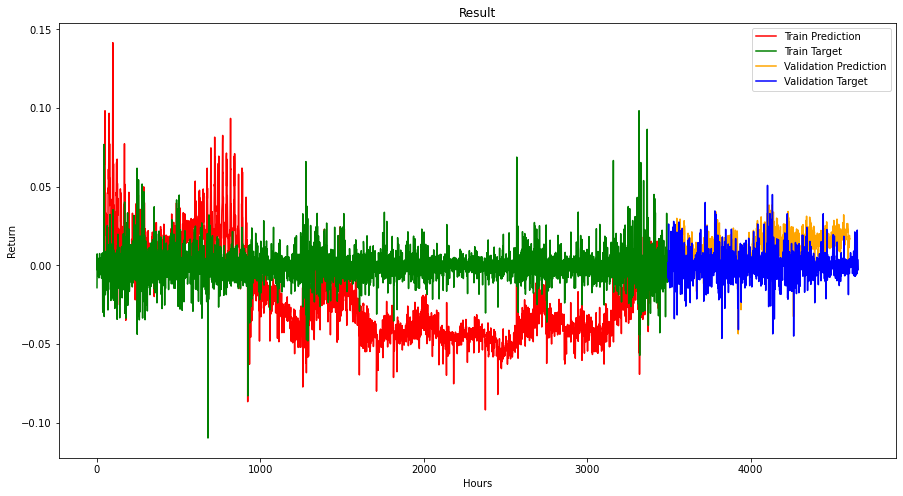

In [5]:
#Plot result
plt.figure(figsize=(15,8))
plt.xlabel('Hours')
plt.ylabel('Return')
plt.plot(train_df['Predicted Return'], label= 'Train Prediction', color= 'r')
plt.plot(train_df['Return'], label= 'Train Target', color= 'g')
plt.plot([None]*len(train_df) + list(val_df['Predicted Return']), label= 'Validation Prediction', color= 'orange')
plt.plot([None]*len(train_df) + list(val_df['Return']), label= 'Validation Target', color= 'b')
plt.legend()
plt.title('Result')